# Optimization of a State-to-State Transfer in a Two-Level-System

In [1]:
# NBVAL_IGNORE_OUTPUT
%load_ext watermark
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
%watermark -v --iversions

qutip       4.3.1
numpy       1.15.4
scipy       1.1.0
matplotlib  3.0.2
matplotlib.pylab  1.15.4
krotov      0.0.1
CPython 3.6.7
IPython 7.1.1


$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2} \mid #2\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}$

The purpose of this example is not to solve an especially interesting physical problem but to give a rather simple example of how the package can be used in order to solve an optimization problem.

## Define the Hamiltonian

In the following the Hamiltonian, guess field and
states are defined.

The Hamiltonian $\op{H}_{0} = - \omega \op{\sigma}_{z}$ represents a
simple qubit with energy
level splitting $\omega$ in the basis $\{\ket{0},\ket{1}\}$. The control
field $\epsilon(t)$ is assumed to couple via the
Hamiltonian $\op{H}_{1}(t) =
\epsilon(t) \op{\sigma}_{x}$ to the qubit, i.e., the control
field effectively drives
transitions between both qubit states. For now, we initialize the control field as constant.

In [20]:
def ham_and_states(omega=1.0, ampl0=0.2):
    """Two-level-system Hamiltonian
    
    Args:
        omega (float): energy separation of the qubit levels
        ampl0 (float): constant amplitude of the driving field
    """
    H0 = - 0.5 * omega * qutip.operators.sigmaz()
    H1 = qutip.operators.sigmax()
    
    psi0 = qutip.Qobj(np.array([1,0]))
    psi1 = qutip.Qobj(np.array([0,1]))

    eps0 = lambda t, args: ampl0
    return ([H0, [H1, eps0]], psi0, psi1)

H, psi0, psi1 = ham_and_states()

The projectors $\op{P}_0 = \ket{0}\bra{0}$ and $\op{P}_1 = \ket{1}\bra{1}$ are introduced since they allow for calculating the
population in the respective states later on.

In [3]:
proj0 = psi0 * psi0.dag()
proj1 = psi1 * psi1.dag()

## Define the optimization target

First we define the time grid of the
dynamics, i.e., by taking the following
values as an example, we define the
initial state to be at time $t=0$ and
consider a total propagation time of
$T=5$. The entire time grid is divided into
$n_{t}=500$ equidistant time steps.

In [4]:
tlist = np.linspace(0, 5, 500)

Next, we define the optimization targets, which is technically a list of objectives, but here it has just one entry defining a simple state-to-state transfer
from initial state $\ket{\Psi_{\init}} = \ket{0}$ to the target state
$\ket{\Psi_{\tgt}} = \ket{1}$, which we want to reach at final time $T$. Note
that we also have to pass the Hamiltonian $\op{H}(t)$ that determines the dynamics of
the system to the optimization objective.

In [5]:
objectives = [
    krotov.Objective(initial_state=psi0, target_state=psi1, H=H)
]

In addition, we have to define and assign a shape function $S(t)$ for the update in each control iteration to each
control field that will be updated. This shape usually takes care of
experimental limits such as the necessity of finite ramps at the beginning and
end of the control field or other conceivable limitations for field shapes: wherever $S(t)$ is zero, the optimization will not change the value of the control from the original guess.

In [6]:
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(t, t_start=0, t_stop=5, t_rise=0.3, t_fall=0.3, func='sinsq')

At this point, we also change the initial control field $\epsilon_{0}(t)$ from a constant to a shaped pulse that switches on smoothly from zero and again switches off at the final time $T$. We re-use the shape function $S(t)$ that we defined for the updates for this purpose (although generally, $S(t)$ for the updates has nothing to with the shape of the control field).

In [7]:
def shape_field(eps0):
    """Applies the shape function S(t) to the guess field"""
    eps0_shaped = lambda t, args: eps0(t, args)*S(t)
    return eps0_shaped

H[1][1] = shape_field(H[1][1])

Having defined the shape function $S(t)$ and having shaped the guess field, we now tell the optimization to also use $S(t)$ as the update-shape for $\epsilon_0(t)$. In addition, we have to choose `lambda_a` for each control field. It controls the update magnitude of the respective field in each iteration.

In [8]:
pulse_options = {
    H[1][1]: krotov.PulseOptions(lambda_a=5, shape=S)
}

It is convenient to introduce the function `print_fidelity`, which can be passed to the optimization procedure and will be called after each iteration and thus provides additional feedback about the optimization progress. 

In [9]:
def print_fidelity(**args):
    F_re = np.average(np.array(args['tau_vals']).real)
    print("    F = %f" % F_re)
    return F_re

## Simulate dynamics of the guess field

Before heading towards the optimization
procedure, we first simulate the
dynamics under the guess field
$\epsilon_{0}(t)$.

In [10]:
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    plt.show(fig)

The following plot shows the guess field $\epsilon_{0}(t)$, which is, as chosen
above, just a constant field (with a smooth switch-on and switch-off)

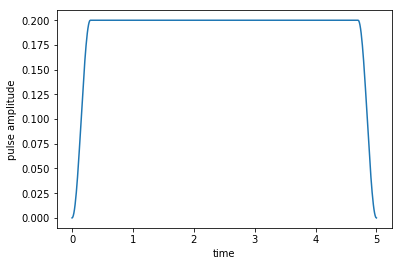

In [11]:
plot_pulse(H[1][1], tlist)

The next line solves the equation of motion for the defined objective, which
contains the initial state $\ket{\Psi_{\init}}$ and the Hamiltonian $\op{H}(t)$
defining its evolution.

In [12]:
guess_dynamics = objectives[0].mesolve(tlist, e_ops=[proj0, proj1])

The plot of the population dynamics shows that the guess field does not transfer
the initial state $\ket{\Psi_{\init}} = \ket{0}$ to the desired target state
$\ket{\Psi_{\tgt}} = \ket{1}$.

In [13]:
def plot_population(result):
    fig, ax = plt.subplots()
    ax.plot(result.times, result.expect[0], label='0')
    ax.plot(result.times, result.expect[1], label='1')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)

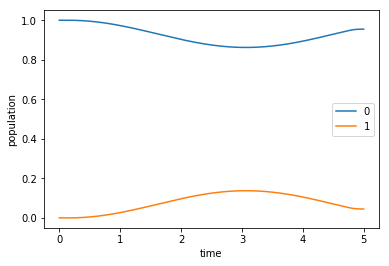

In [14]:
plot_population(guess_dynamics)

## Optimize

In the following we optimize the guess field $\epsilon_{0}(t)$ such
that the intended state-to-state transfer $\ket{\Psi_{\init}} \rightarrow \ket{\Psi_{\tgt}}$ is solved.

The cell below carries out the optimization. It requires, besides the
previously defined optimization `objectives`, information about the
optimization functional $F$ (via `chi_constructor`) and the propagation method that should be used. In
addition, the number of total iterations is required and, as an option, we pass
an info-hook that after each iteration combines a complete printout of the state of the optimization with the `print_fidelity` function defined above.

Here, we choose $F = F_{re}$ with
\begin{equation}
F_{re}
= \Re\Braket{\Psi(T)}{\Psi_{\tgt}}
\end{equation}

with $\ket{\Psi(T)}$ the forward propagated state of $\ket{\Psi_{\init}}$.

In [15]:
oct_result = krotov.optimize_pulses(
    objectives, pulse_options, tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_re,
    info_hook=krotov.info_hooks.chain(
        krotov.info_hooks.print_debug_information,
        print_fidelity),
    iter_stop=10)

Iteration 0
    objectives:
        1:|(2)⟩ - {[Herm[2,2], [Herm[2,2], u1(t)]]} - |(2)⟩
    adjoint objectives:
        1:⟨(2)| - {[Herm[2,2], [Herm[2,2], u1(t)]]} - ⟨(2)|
    λₐ: 5.00e+00
    duration: 0.6 secs (started at 2018-11-20 09:21:25)
    τ: (2.12e-01:0.50π)
    F = 0.000000
Iteration 1
    duration: 1.3 secs (started at 2018-11-20 09:21:26)
    τ: (3.16e-01:0.23π)
    F = 0.235157
Iteration 2
    duration: 1.3 secs (started at 2018-11-20 09:21:27)
    τ: (4.91e-01:0.14π)
    F = 0.444066
Iteration 3
    duration: 1.3 secs (started at 2018-11-20 09:21:29)
    τ: (6.44e-01:0.10π)
    F = 0.611354
Iteration 4
    duration: 1.4 secs (started at 2018-11-20 09:21:30)
    τ: (7.60e-01:0.08π)
    F = 0.735071
Iteration 5
    duration: 1.3 secs (started at 2018-11-20 09:21:31)
    τ: (8.41e-01:0.07π)
    F = 0.821734
Iteration 6
    duration: 1.3 secs (started at 2018-11-20 09:21:33)
    τ: (8.96e-01:0.06π)
    F = 0.880461
Iteration 7
    duration: 1.3 secs (started at 2018-11-20 09

The following prints out information about the optimization procedure.

In [16]:
oct_result

Krotov Optimization Result
--------------------------
- Started at 2018-11-20 09:21:25
- Number of objectives: 1
- Number of iterations: 10
- Ended at 2018-11-20 09:21:39

## Simulate dynamics of the optimized field

Having obtained the optimized
control field, we can now
plot it and calculate the
population dynamics under this field.

The optimized field ranges from negative
to positive values and has no
particular shape.

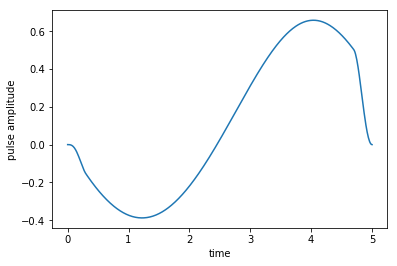

In [17]:
plot_pulse(oct_result.optimized_controls[0], tlist)

In contrast to the dynamics under the guess field, the optimized field indeed
drives the initial state $\ket{\Psi_{\init}} = \ket{0}$ to the desired target
state $\ket{\Psi_{\tgt}} = \ket{1}$.

In [18]:
opt_dynamics = oct_result.optimized_objectives[0].mesolve(
    tlist, e_ops=[proj0, proj1]
)

/home/daniel/krotov/.venv/py36/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/daniel/krotov/docs/notebooks/rhs181180.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


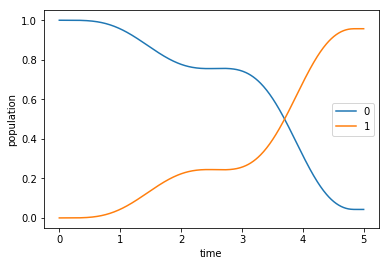

In [19]:
plot_population(opt_dynamics)